In [128]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from pprint import pprint
import math
import io
import random

In [129]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.csv to data (13).csv
User uploaded file "data.csv" with length 28592 bytes


In [130]:
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))
data = data.replace(to_replace='^\s+$', value= np.nan, regex=True)
data=data.dropna(how='any')
titanic=pd.DataFrame(data).to_numpy()

In [131]:
# get mean & stddev for each class
def summarize_by_class(dataset):
	separated = separate_by_class(dataset)
	summaries = dict()
	for class_value, rows in separated.items():
		summaries[class_value] = row_wise_summary(rows)
	return summaries

In [132]:
# Split the dataset by class values, returns a dictionary
def separate_by_class(dataset):
	separated = dict()
	for i in range(len(dataset)):
		vector = dataset[i]
		class_value = vector[-1] # class_value at last pos
		if (class_value not in separated):
			separated[class_value] = list()
		separated[class_value].append(vector)
	return separated # dictionary with each class mapped to a list of rows having that class value

In [133]:
# Calculate mean & stddev of each column in the rows
def row_wise_summary(rows):
	summaries = [(np.mean(column), np.std(column), len(column)) for column in zip(*rows)]
	del(summaries[-1]) # remove last column (label)
	return summaries

In [134]:
# returns predictions for a set of examples 
def get_predictions(summaries, test_data): 
    predictions = [] 
    for i in range(len(test_data)): 
        result = predict(summaries, test_data[i]) 
        predictions.append(result) 
    return predictions 

In [135]:
# Make prediction - highest probability is the prediction 
def predict(summaries, test_data_row): 
    probabilities = calc_class_probabilities(summaries, test_data_row) 
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items(): 
        if best_label is None or probability > best_prob: 
            best_prob = probability 
            best_label = class_value 
    return best_label

Below Image taken from -> https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c

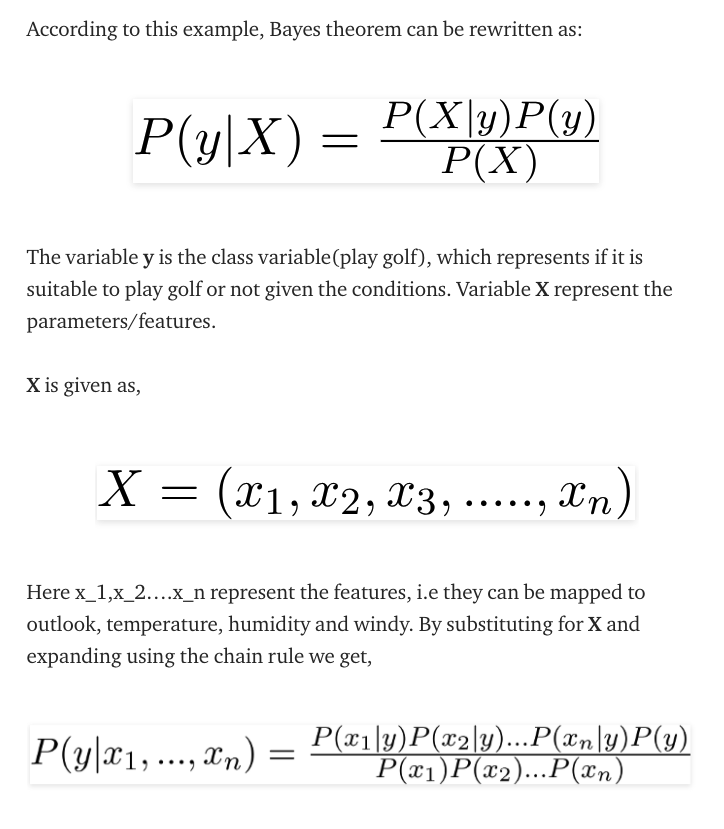

In [136]:
# Calculate Class Probabilities 
def calc_class_probabilities(summaries, test_data_row):
    total_rows = sum([summaries[label][0][2] for label in summaries]) # summaries[label][0][2] is count
    probabilities = {} 
    for class_value, class_summaries in summaries.items(): 
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
        for i in range(len(class_summaries)):   # iterating across each column of the row
            mean, std_dev,_ = class_summaries[i] 
            x = test_data_row[i] # value of that particular column
            probabilities[class_value] *= calc_gauss_probability(x, mean, std_dev) 
    return probabilities 

## Likelihood
We will now calculate the probability or likelihood of a data point to belong to a certain class.

One way we can do this is to assume that data is drawn from a distribution, such as a bell curve or Gaussian distribution.

The function which calculates the likelihood of data point using Gaussian density function. 
<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/f0506065a47bd1efc86fe9aa01a1ed66c6846a02>

In [137]:
# Calculate Gaussian Probability
def calc_gauss_probability(x, mean, stdev): 
    expo = math.exp(-(math.pow(x - mean, 2) / (2 * math.pow(stdev, 2)))) 
    return (1 / (math.sqrt(2 * math.pi) * stdev)) * expo 

In [138]:
# Calculate Accuracy 
def accuracy_rate(test, predictions): 
    correct = 0
    for i in range(len(test)): 
        if test[i][-1] == predictions[i]: 
            correct += 1
    return round((correct / float(len(test))),3)*100

In [139]:
# Calculate precision
def precision(test,predictions):
  tp = 0 # true positive
  fp = 0 # false positive
  for i in range(len(test)):
    if test[i][-1] == 1:
      if test[i][-1] == predictions[i]:
        tp += 1
      else:
        fp += 1
  return round((tp/float(tp+fp))*100,1)


In [140]:
TEST_SIZE = 0.3

In [141]:
from sklearn.naive_bayes import GaussianNB
# Calculate sklearn naive bayes accuracy
def get_sklearn_metrics(dataset, tes_size):
    X = dataset[:,:-1]
    Y = dataset[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=tes_size,random_state=20)

    classifier = GaussianNB()
    classifier.fit(X_train, y_train)
    predicts = classifier.predict(X_test)
    accuracy = round(accuracy_score(y_test, predicts), 3) * 100
    precision = round(precision_score(y_test,predicts),3) * 100
    return accuracy,precision

In [142]:
# Splitting the dataset to train & test data
train_data, test_data = train_test_split(titanic, test_size=TEST_SIZE, random_state=42)

In [143]:
# prepare model 
summaries = summarize_by_class(train_data)

In [144]:
summaries[0]

[(29.908333333333335, 12.380378783237012, 690),
 (28.635585507246375, 46.3326127647529, 690),
 (0.263768115942029, 0.44067504689331044, 690),
 (0.48985507246376814, 1.0525531316461123, 690),
 (0.35797101449275365, 0.9406913580148901, 690),
 (2.402898550724638, 0.7949060676424047, 690),
 (1.536231884057971, 0.7835206709985114, 690)]

In [145]:
# test model 
predictions = get_predictions(summaries, test_data) 

In [146]:
# sklearn test
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.3)

In [147]:
# Accuracy
accuracy = accuracy_rate(test_data, predictions)
print("Accuracy of your model is: ", accuracy)
print("Accuracy of model with sklearn naive bayes : ", sklearn_accuracy)



Accuracy of your model is:  74.6
Accuracy of model with sklearn naive bayes :  76.3


In [148]:
# Precision
precision_val = precision(test_data, predictions)
print("Precision of your model is: ", precision_val)

Precision of your model is:  31.0



# Sources and Credits:
* Sandro Skansi: Chapter 3, Part 3
* Machine Learning Mastery: https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
* Geeks for Geeks: https://www.geeksforgeeks.org/ml-naive-bayes-scratch-implementation-using-python/

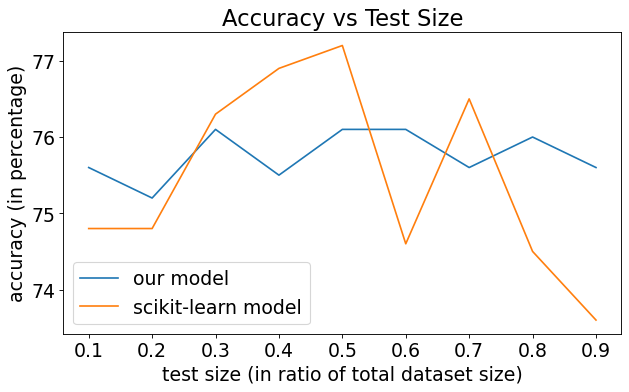

In [149]:

# this code section plots accuracy vs test size

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 17})

figure(num=None, figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')


our_accu = []
test_size_arr = []
sk_accu = []

test_size_arr.append(0.1)
test_size_arr.append(0.2)
test_size_arr.append(0.3)
test_size_arr.append(0.4)
test_size_arr.append(0.5)
test_size_arr.append(0.6)
test_size_arr.append(0.7)
test_size_arr.append(0.8)
test_size_arr.append(0.9)

train_data, test_data = train_test_split(titanic, test_size=0.1, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.1)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

train_data, test_data = train_test_split(titanic, test_size=0.2, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.2)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

train_data, test_data = train_test_split(titanic, test_size=0.3, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.3)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

train_data, test_data = train_test_split(titanic, test_size=0.4, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.4)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

train_data, test_data = train_test_split(titanic, test_size=0.5, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.5)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

train_data, test_data = train_test_split(titanic, test_size=0.6, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.6)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

train_data, test_data = train_test_split(titanic, test_size=0.7, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.7)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

train_data, test_data = train_test_split(titanic, test_size=0.8, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.8)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

train_data, test_data = train_test_split(titanic, test_size=0.9, random_state=20)
predictions = get_predictions(summaries, test_data) 
accuracy = accuracy_rate(test_data, predictions)
sklearn_accuracy,sklearn_precision = get_sklearn_metrics(titanic, 0.9)
our_accu.append(accuracy)
sk_accu.append(sklearn_accuracy)

plt.plot(test_size_arr, our_accu, label = "our model")
plt.plot(test_size_arr, sk_accu, label = "scikit-learn model")

plt.xlabel('test size (in ratio of total dataset size)') 
# naming the y axis 
plt.ylabel('accuracy (in percentage)') 
# giving a title to my graph 
plt.title('Accuracy vs Test Size') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 


No handles with labels found to put in legend.


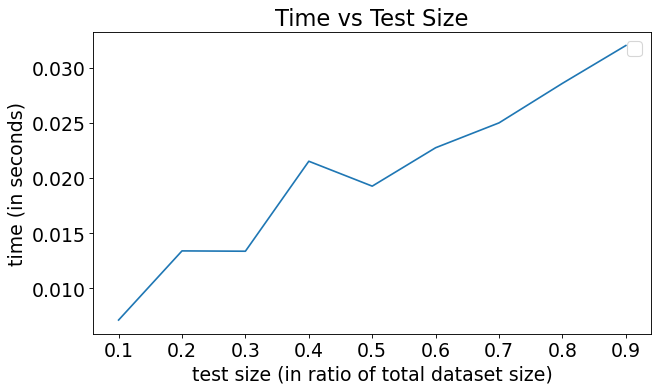

In [150]:
# this code section plots time taken for training vs test size

import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 17})

figure(num=None, figsize=(9, 5), dpi=80, facecolor='w', edgecolor='k')

#from timeit import default_timer as timer

time_arr = []
test_size_arr = []

test_size_arr.append(0.1)
test_size_arr.append(0.2)
test_size_arr.append(0.3)
test_size_arr.append(0.4)
test_size_arr.append(0.5)
test_size_arr.append(0.6)
test_size_arr.append(0.7)
test_size_arr.append(0.8)
test_size_arr.append(0.9)

#test_size_arr.append(0.1)

train_data, test_data = train_test_split(titanic, test_size=0.1, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)

train_data, test_data = train_test_split(titanic, test_size=0.2, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)

train_data, test_data = train_test_split(titanic, test_size=0.3, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)

train_data, test_data = train_test_split(titanic, test_size=0.4, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)

train_data, test_data = train_test_split(titanic, test_size=0.5, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)

train_data, test_data = train_test_split(titanic, test_size=0.6, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)

train_data, test_data = train_test_split(titanic, test_size=0.7, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)

train_data, test_data = train_test_split(titanic, test_size=0.8, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)

train_data, test_data = train_test_split(titanic, test_size=0.9, random_state=42)
start = time.time()
summaries = summarize_by_class(train_data)
predictions = get_predictions(summaries, test_data)
end = time.time()
time_arr.append(end - start)


plt.plot(test_size_arr, time_arr)

plt.xlabel('test size (in ratio of total dataset size)') 
# naming the y axis 
plt.ylabel('time (in seconds)') 
# giving a title to my graph 
plt.title('Time vs Test Size') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 